In [1]:
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn import neighbors

# Data Preparation

In [2]:
%%time
#200000 compounds with 469 features
all_features = pd.read_csv("c2vpoint2m.txt.gz", sep="\t", header=None)

CPU times: user 22.8 s, sys: 8.7 s, total: 31.5 s
Wall time: 1min 50s


In [ ]:
#make the compound names the index
all_features.set_index(0, inplace=True)

In [ ]:
%%time
#725634 compounds with target and activity
cgan = pd.read_csv("activities.txt.gz", sep="\t")

In [ ]:
#we are only interested in the compounds whose target is EGFR
egfr_activity = cgan[cgan['target'] == 'EGFR'].set_index('compound')

In [ ]:
#separate into two dataframes, one with active compounds
egfr_active = egfr_activity[egfr_activity['activity'] >= 6]
egfr_active_compounds = egfr_active.index.values

In [ ]:
#and one with inactive ones
egfr_inactive = egfr_activity[egfr_activity['activity']  < 6]
egfr_inactive_compounds = egfr_inactive.index.values

In [ ]:
#5275 compounds with EGFR target and 469 features
egfr_features = pd.read_csv("egfr.c2v.txt", sep="\t", header=None).set_index(0)

In [ ]:
#isolate the names for easier access
egfr_compounds = egfr_features.index.values

In [ ]:
#make dataframes with features for the active and inactive compounds
egfr_active_features = egfr_features.loc[egfr_active_compounds]
egfr_inactive_features = egfr_features.loc[egfr_inactive_compounds]

In [ ]:
#scale the data so that each feature is normalized and can be compared to other features
min_max_scaler = preprocessing.MinMaxScaler() #fits data between 0 and 1

In [ ]:
#normalize the active compounds
egfr_active_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_active_features), 
                                         index=egfr_active_features.index)

In [ ]:
#normalize the inactive compounds
egfr_inactive_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_inactive_features), 
                                           index=egfr_inactive_features.index)

In [ ]:
#remove duplicates from all_features - can also use DataFrame.drop_duplicates()
all_features_cleaned = all_features.loc[list(set(all_features.index.values) - set(egfr_compounds))]

In [ ]:
#normalize the database
all_features_cleaned_norm = pd.DataFrame(min_max_scaler.fit_transform(all_features_cleaned), index=all_features_cleaned.index)

# Logic Creation

In [ ]:
def dataprep(active, rest, size, seed):
    #create the query from a random sample of the data
    size = int(active.shape[0] * size + .5)
    query = active.sample(n=size, random_state=seed)
    
    #remove the query, then concatenate the remaining data for training
    sub = list(set(active.index.values) - set(query.index.values))
    active_minus_query = active.loc[sub]
    database = pd.concat([active_minus_query] + rest)
    
    return database, query

In [ ]:
def buildsklearnModel(database, n_neighbors, algorithm, metric):
    model = neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
    
    #train the model
    start = time.time()
    model.fit(database)
    end = time.time()
    
    build_time = end - start
    
    return model, build_time

In [ ]:
def runsklearnQuery(model, query, n_neighbors, database, active):
    #run the query
    start = time.time()
    _, indices = model.kneighbors(query)
    end = time.time()
    
    query_time = end - start
    
    #assess the quality of the results - how many of the neighbors are in the success dataframe
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if database.index.values[j] in active.index.values:
                count += 1
        sum += count / float(k)
    average = sum / query.shape[0]
    
    return average, query_time

In [ ]:
def sklearnNN(active, rest, size, n_neighbors, algorithm, metric, seed):
    #prepare the data
    database, query = dataprep(active, rest, size, seed)
    
    #build the model
    model, build_time = buildsklearnModel(database, n_neighbors, algorithm, metric)
    
    #run the query
    average, query_time = runsklearnQuery(model, query, n_neighbors, database, active)
    
    #return the results in a table
    d = OrderedDict({'algorithm/index':[algorithm], 'n_neighbors':[n_neighbors], 'query size':[size], 'metric':[metric], 
                     'build time (s)':[time_to_build], 'query time (s)':[time_to_query], 'quality':[average], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

# Tests

In [ ]:
sklearn_results = pd.DataFrame()

In [ ]:
#brute-force algorithm
temp = []
for metric in ['euclidean', 'cosine']:
    #5 trials
    for seed in range(5): 
        temp.append(sklearnNN(active=egfr_active_features_norm, rest=[all_features_cleaned_norm, egfr_inactive_features_norm],
                             size=0.2, n_neighbors=100, algorithm='brute', metric=metric, seed=seed))
sklearn_results = pd.concat([sklearn_results] + temp)

In [ ]:
#other algorithms
temp = []
for algorithm in ['kd_tree', 'ball_tree']:
    for seed in range(5):
        temp.append(sklearnNN(egfr_active_features_norm, [all_features_cleaned_norm, egfr_inactive_features_norm],
                             0.2, 100, algorithm, metric='euclidean', seed=seed))
sklearn_results = pd.concat([sklearn_results] + temp)

In [16]:
sklearn_results

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,brute,euclidean,100,0.2,0.165012,4.812468,0.998022,0
1,brute,euclidean,100,0.2,0.087079,4.793198,0.996231,1
2,brute,euclidean,100,0.2,0.088285,4.209342,0.997836,2
3,brute,euclidean,100,0.2,0.076634,4.175714,0.998507,3
4,brute,euclidean,100,0.2,0.080415,4.325893,0.998433,4
5,brute,cosine,100,0.2,0.094218,6.116019,0.998060,0
6,brute,cosine,100,0.2,0.088929,5.694500,0.996250,1
7,brute,cosine,100,0.2,0.090712,5.534836,0.997836,2
8,brute,cosine,100,0.2,0.077965,5.698534,0.999123,3
9,brute,cosine,100,0.2,0.082029,5.734892,0.999030,4


# Graphs

In [17]:
a = sklearn_results

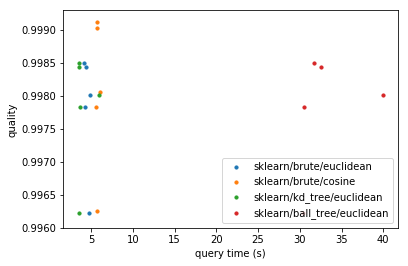

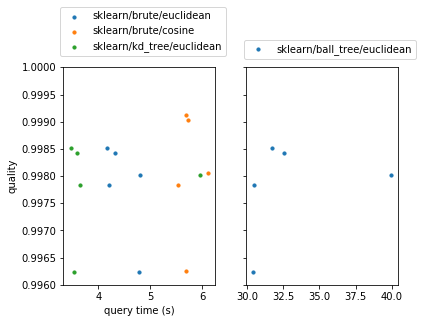

In [70]:
#graph of query time vs quality for each of the algorithm/metric combinations
plt.figure()
for i in range(0, 25, 5):
    plt.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)
plt.ylim(0.996, 0.9993)
plt.xlabel('query time (s)')
plt.ylabel('quality')
plt.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean', 'sklearn/ball_tree/euclidean'])


#broken x-axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')

for i in range(0, 15, 5):
    ax.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)

ax2.scatter(a[15:20]['query time (s)'], a[15:20]['quality'], s=10)

plt.ylim(0.996, 0.9993)

ax.set_xlabel('query time (s)')
ax.set_ylabel('quality')

ax.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean'], bbox_to_anchor=(1.1, 1.3))
ax2.legend(['sklearn/ball_tree/euclidean'], bbox_to_anchor=(1.15, 1.15))

plt.show()

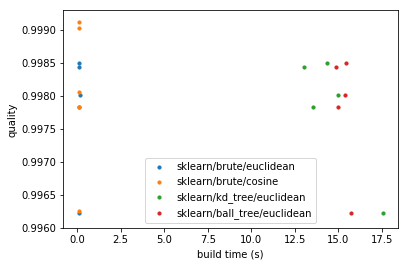

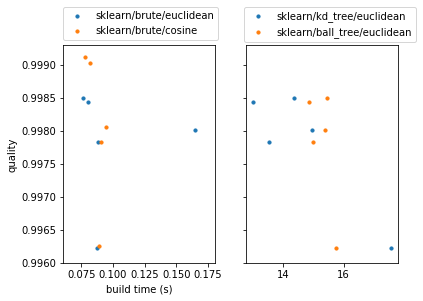

In [71]:
#graph of build time vs quality for each of the algorithm/metric combinations
plt.figure()
for i in range(0, 25, 5):  
    plt.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['quality'], s=10)

plt.ylim(0.996, 0.9993)
plt.xlabel('build time (s)')
plt.ylabel('quality')
plt.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean', 
            'sklearn/ball_tree/euclidean'])



#broken x-axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
for i in range(0, 10, 5):
    ax.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['quality'], s=10)
    ax2.scatter(a[i+10:i+15]['build time (s)'], a[i+10:i+15]['quality'], s=10)
    
plt.ylim(0.996, 0.9993)
    
ax.set_xlabel('build time (s)')
ax.set_ylabel('quality')

ax.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine'], bbox_to_anchor=(1.05, 1.2))
ax2.legend(['sklearn/kd_tree/euclidean', 'sklearn/ball_tree/euclidean'], bbox_to_anchor=(1.15, 1.2))

plt.show()